In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Datasets/OCT2017_dataset.zip

Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
target_size = (299, 299)

train_datagen = ImageDataGenerator( rotation_range=20,
                                    width_shift_range=0.4,
                                    height_shift_range=0.4,
                                    shear_range=0.2,
                                    zoom_range=0.1,
                                    channel_shift_range=0.0,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/OCT2017/train',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        '/content/OCT2017/val',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


# Model InceptionV3(2 Layer)

In [ ]:
from tensorflow.keras.applications.inception_v3  import InceptionV3
from tensorflow.keras.applications.inception_v3  import preprocess_input
from tensorflow.keras.layers import Input
import numpy as np

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Input,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy,categorical_crossentropy

In [ ]:
feature_extractor_Incept= InceptionV3(weights='imagenet',
                          input_shape=(299, 299, 3),
                          include_top=False)
feature_extractor_Incept.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

In [ ]:
for layer in feature_extractor_Incept.layers[0 :-17]:
    layer.trainable = False

feature_extractor_Incept.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

In [ ]:
inp_layer = Input(shape = (299, 299, 3))
features2 = feature_extractor_Incept(inp_layer)

flat = Flatten()(features2)
FC1 = Dense(units = 300, activation = 'relu')(flat)
FC2 = Dense(units = 200, activation = 'relu')(FC1)
output = Dense(units = 4, activation = 'softmax')(FC2)

model2 = Model(inputs = inp_layer, outputs = output)

model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_3 (Dense)             (None, 300)               39321900  
                                                                 
 dense_4 (Dense)             (None, 200)               60200     
                                                                 
 dense_5 (Dense)             (None, 4)                 804       
                                                                 
Total params: 61,185,688
Trainable params: 40,433,528
Non-t

In [ ]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/checkpoints{epoch:02d}.h5',period=1,save_weights_only=False)

In [ ]:
opt = Adam(learning_rate = 0.0001)
model2.compile(optimizer = opt, loss=categorical_crossentropy, metrics = 'acc')

In [ ]:
results_InceptionV3 = model2.fit(train_generator,
                    epochs = 5,
                    validation_data=validation_generator,
                    callbacks=[model_checkpoint])

Epoch 1/5
5218/5218 [==============================] - 1994s 381ms/step - loss: 0.5589 - acc: 0.7977 - val_loss: 0.0971 - val_acc: 1.0000
Epoch 2/5
5218/5218 [==============================] - 1972s 378ms/step - loss: 0.4271 - acc: 0.8467 - val_loss: 0.1314 - val_acc: 0.9688
Epoch 3/5
5218/5218 [==============================] - 1972s 378ms/step - loss: 0.3893 - acc: 0.8587 - val_loss: 0.0574 - val_acc: 1.0000
Epoch 4/5
5218/5218 [==============================] - 1965s 377ms/step - loss: 0.3707 - acc: 0.8663 - val_loss: 0.0819 - val_acc: 1.0000
Epoch 5/5
5218/5218 [==============================] - 1943s 372ms/step - loss: 0.3583 - acc: 0.8730 - val_loss: 0.0701 - val_acc: 1.0000


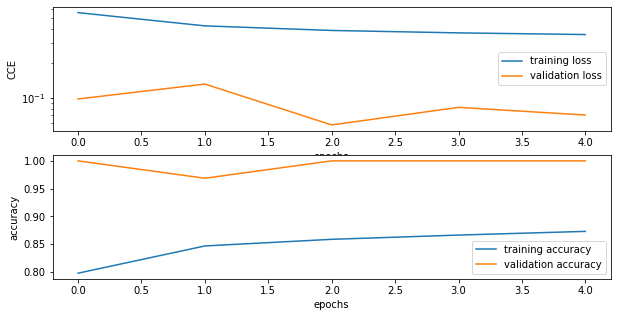

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_loss = results_InceptionV3.history['loss']
val_loss = results_InceptionV3.history['val_loss']
train_acc = results_InceptionV3.history['acc']
val_acc = results_InceptionV3.history['val_acc']

plt.subplots(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('CCE')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()


In [ ]:
from keras.models import load_model

In [ ]:
conti_model = load_model('/content/drive/MyDrive/checkpoints05.h5')

In [ ]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/checkpoints{epoch:01d}.h5',period=1,save_weights_only=False)

In [ ]:
conti_results = conti_model.fit(train_generator,
                    epochs = 5,
                    validation_data=validation_generator,
                    callbacks=[model_checkpoint])

Epoch 1/5
5218/5218 [==============================] - 1977s 378ms/step - loss: 0.3476 - acc: 0.8763 - val_loss: 0.0626 - val_acc: 1.0000
Epoch 2/5
5218/5218 [==============================] - 1979s 379ms/step - loss: 0.3416 - acc: 0.8775 - val_loss: 0.1055 - val_acc: 0.9688
Epoch 3/5
5218/5218 [==============================] - 2011s 385ms/step - loss: 0.3290 - acc: 0.8822 - val_loss: 0.0743 - val_acc: 1.0000
Epoch 4/5
5218/5218 [==============================] - 1989s 381ms/step - loss: 0.3256 - acc: 0.8837 - val_loss: 0.0902 - val_acc: 1.0000
Epoch 5/5
5218/5218 [==============================] - 1980s 379ms/step - loss: 0.3203 - acc: 0.8846 - val_loss: 0.1187 - val_acc: 0.9688


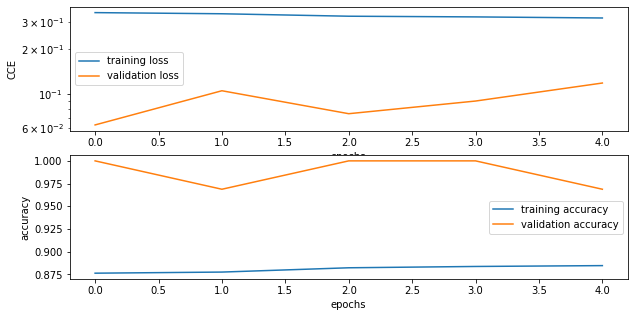

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_loss = conti_results.history['loss']
val_loss =   conti_results.history['val_loss']
train_acc =  conti_results.history['acc']
val_acc =  conti_results.history['val_acc']

plt.subplots(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('CCE')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()


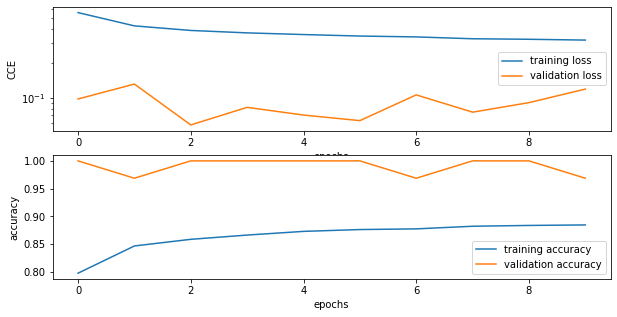

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_loss = results_InceptionV3.history['loss']+conti_results.history['loss']
val_loss = results_InceptionV3.history['val_loss']+  conti_results.history['val_loss']
train_acc = results_InceptionV3.history['acc'] + conti_results.history['acc']
val_acc = results_InceptionV3.history['val_acc'] + conti_results.history['val_acc']

plt.subplots(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('CCE')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        '/content/OCT2017/test',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [ ]:
y_pred_test_Incept = conti_model.predict(test_generator)

In [ ]:
y_pred_test_Incept=np.argmax(y_pred_test_Incept,axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_generator.classes, y_pred_test_Incept))

[[238   3   0   1]
 [  2 238   0   2]
 [ 26   3 210   3]
 [  0   0   0 242]]


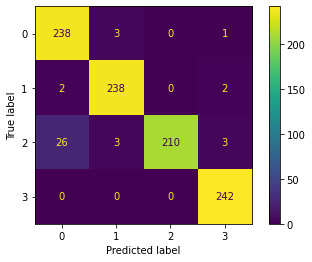

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_generator.classes, y_pred_test_Incept)

In [ ]:
from sklearn.metrics import classification_report
cls_report = classification_report(test_generator.classes, y_pred_test_Incept)

print(cls_report)

              precision    recall  f1-score   support

           0       0.89      0.98      0.94       242
           1       0.98      0.98      0.98       242
           2       1.00      0.87      0.93       242
           3       0.98      1.00      0.99       242

    accuracy                           0.96       968
   macro avg       0.96      0.96      0.96       968
weighted avg       0.96      0.96      0.96       968



In [ ]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = conti_results.history
# Save it under the form of a json file
json.dump(history_dict, open('/content/drive/MyDrive/InceptionV3_6(2 layer).json', 'w'))